In [1]:
import random
from shapely.geometry import box
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from sklearn.metrics import auc
from tqdm.notebook import tqdm

In [2]:
# Function to compute IoU using Shapely
def compute_iou_shapely(box1, box2):
    """
    Compute IoU between two bounding boxes using Shapely
    
    Parameters:
    box1, box2: Bounding boxes in format [x_center, y_center, width, height]
                where all values are normalized (0-1)
    
    Returns:
    iou: Intersection over Union value
    """
    # Convert from YOLO format [x_center, y_center, width, height] to 
    # [xmin, ymin, xmax, ymax] format for shapely
    
    # Box 1
    x_center1, y_center1, width1, height1 = box1
    xmin1 = x_center1 - width1/2
    ymin1 = y_center1 - height1/2
    xmax1 = x_center1 + width1/2
    ymax1 = y_center1 + height1/2
    
    # Box 2
    x_center2, y_center2, width2, height2 = box2
    xmin2 = x_center2 - width2/2
    ymin2 = y_center2 - height2/2
    xmax2 = x_center2 + width2/2
    ymax2 = y_center2 + height2/2
    
    # Create shapely boxes
    shapely_box1 = box(xmin1, ymin1, xmax1, ymax1)
    shapely_box2 = box(xmin2, ymin2, xmax2, ymax2)
    
    # Compute intersection and union
    intersection = shapely_box1.intersection(shapely_box2).area
    union = shapely_box1.union(shapely_box2).area
    
    # Compute IoU
    iou = intersection / union if union > 0 else 0
    
    return iou

In [3]:
# Function to compute IoU using manual calculation (for comparison)
def compute_iou_manual(box1, box2):
    """
    Compute IoU between two bounding boxes using manual calculation
    
    Parameters:
    box1, box2: Bounding boxes in format [x_center, y_center, width, height]
    
    Returns:
    iou: Intersection over Union value
    """
    # Convert from YOLO format [x_center, y_center, width, height] to 
    # [xmin, ymin, xmax, ymax] format
    
    # Box 1
    x_center1, y_center1, width1, height1 = box1
    xmin1 = x_center1 - width1/2
    ymin1 = y_center1 - height1/2
    xmax1 = x_center1 + width1/2
    ymax1 = y_center1 + height1/2
    
    # Box 2
    x_center2, y_center2, width2, height2 = box2
    xmin2 = x_center2 - width2/2
    ymin2 = y_center2 - height2/2
    xmax2 = x_center2 + width2/2
    ymax2 = y_center2 + height2/2
    
    # Calculate intersection
    xmin_inter = max(xmin1, xmin2)
    ymin_inter = max(ymin1, ymin2)
    xmax_inter = min(xmax1, xmax2)
    ymax_inter = min(ymax1, ymax2)
    
    if xmin_inter >= xmax_inter or ymin_inter >= ymax_inter:
        return 0.0  # No intersection
    
    intersection = (xmax_inter - xmin_inter) * (ymax_inter - ymin_inter)
    
    # Calculate areas
    area1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area2 = (xmax2 - xmin2) * (ymax2 - ymin2)
    
    # Calculate union
    union = area1 + area2 - intersection
    
    # Compute IoU
    iou = intersection / union if union > 0 else 0
    
    return iou

In [4]:
# Test the IoU functions with some sample boxes
test_boxes = [
    # Box pairs with varying degrees of overlap
    ([0.5, 0.5, 0.2, 0.2], [0.5, 0.5, 0.2, 0.2]),  # Perfect overlap, IoU=1.0
    ([0.5, 0.5, 0.2, 0.2], [0.6, 0.6, 0.2, 0.2]),  # Partial overlap
    ([0.5, 0.5, 0.2, 0.2], [0.8, 0.8, 0.2, 0.2]),  # No overlap, IoU=0.0
    ([0.5, 0.5, 0.3, 0.2], [0.4, 0.5, 0.2, 0.3])   # Different shapes
]

print("Comparing IoU calculations between Shapely and Manual calculation:")
print("-" * 60)
print(f"{'Box 1':<25} {'Box 2':<25} {'Shapely IoU':<15} {'Manual IoU':<15} {'Difference':<10}")
print("-" * 60)

for box1, box2 in test_boxes:
    iou_shapely = compute_iou_shapely(box1, box2)
    iou_manual = compute_iou_manual(box1, box2)
    difference = abs(iou_shapely - iou_manual)
    
    print(f"{str(box1):<25} {str(box2):<25} {iou_shapely:<15.6f} {iou_manual:<15.6f} {difference:<10.6f}")

Comparing IoU calculations between Shapely and Manual calculation:
------------------------------------------------------------
Box 1                     Box 2                     Shapely IoU     Manual IoU      Difference
------------------------------------------------------------
[0.5, 0.5, 0.2, 0.2]      [0.5, 0.5, 0.2, 0.2]      1.000000        1.000000        0.000000  
[0.5, 0.5, 0.2, 0.2]      [0.6, 0.6, 0.2, 0.2]      0.142857        0.142857        0.000000  
[0.5, 0.5, 0.2, 0.2]      [0.8, 0.8, 0.2, 0.2]      0.000000        0.000000        0.000000  
[0.5, 0.5, 0.3, 0.2]      [0.4, 0.5, 0.2, 0.3]      0.333333        0.333333        0.000000  


In [5]:
# Function to compute Average Precision (AP) using Pascal VOC 11-point interpolation
def compute_ap_pascal_voc(precision, recall):
    """
    Compute Average Precision using Pascal VOC 11-point interpolation method
    
    Parameters:
    precision: List of precision values
    recall: List of recall values
    
    Returns:
    ap: Average Precision value
    """
    # Ensure precision and recall are numpy arrays
    precision = np.array(precision)
    recall = np.array(recall)
    
    # 11 recall points for VOC evaluation (0, 0.1, 0.2, ..., 1.0)
    recall_points = np.linspace(0, 1, 11)
    
    # For each recall point, take the maximum precision whose recall value is greater than t
    ap = 0
    for t in recall_points:
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p
    
    # Average over the 11 points
    ap /= 11
    
    return ap

In [6]:
# Function to compute Average Precision (AP) using COCO 101-point interpolation
def compute_ap_coco(precision, recall):
    """
    Compute Average Precision using COCO 101-point interpolation method
    
    Parameters:
    precision: List of precision values
    recall: List of recall values
    
    Returns:
    ap: Average Precision value
    """
    # Ensure precision and recall are numpy arrays
    precision = np.array(precision)
    recall = np.array(recall)
    
    # 101 recall points for COCO evaluation (0, 0.01, 0.02, ..., 1.0)
    recall_points = np.linspace(0, 1, 101)
    
    # For each recall point, take the maximum precision whose recall value is greater than t
    ap = 0
    for t in recall_points:
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p
    
    # Average over the 101 points
    ap /= 101
    
    return ap

In [7]:
# Function to compute Average Precision (AP) using Area under Precision-Recall Curve
def compute_ap_auc(precision, recall):
    """
    Compute Average Precision using Area under Precision-Recall Curve
    
    Parameters:
    precision: List of precision values
    recall: List of recall values
    
    Returns:
    ap: Average Precision value
    """
    # Ensure precision and recall are numpy arrays
    precision = np.array(precision)
    recall = np.array(recall)
    
    # Sort by recall
    indices = np.argsort(recall)
    recall = recall[indices]
    precision = precision[indices]
    
    # Compute area under PR curve using sklearn's auc function
    ap = auc(recall, precision)
    
    return ap

In [8]:
# Function to generate random boxes
def generate_random_box(image_size=100, box_size=20):
    """
    Generate a random bounding box
    
    Parameters:
    image_size: Size of the image (square)
    box_size: Size of the box (square)
    
    Returns:
    box: Bounding box in format [x_center, y_center, width, height] normalized (0-1)
    """
    # Ensure the box stays within the image
    max_pos = image_size - box_size
    
    # Generate random positions
    x = random.randint(box_size // 2, max_pos - box_size // 2) / image_size
    y = random.randint(box_size // 2, max_pos - box_size // 2) / image_size
    w = box_size / image_size
    h = box_size / image_size
    
    return [x, y, w, h]

# Generate random data for evaluation
def generate_random_data(num_images=10, num_boxes=10, image_size=100, box_size=20):
    """
    Generate random ground truth and predicted boxes
    
    Parameters:
    num_images: Number of images
    num_boxes: Number of boxes per image
    image_size: Size of the image (square)
    box_size: Size of the box (square)
    
    Returns:
    gt_boxes: List of ground truth boxes per image
    pred_boxes: List of predicted boxes per image
    pred_scores: List of confidence scores for predicted boxes
    """
    gt_boxes = []
    pred_boxes = []
    pred_scores = []
    
    for _ in range(num_images):
        # Generate ground truth boxes
        gt_image_boxes = [generate_random_box(image_size, box_size) for _ in range(num_boxes)]
        gt_boxes.append(gt_image_boxes)
        
        # Generate predicted boxes with some noise
        pred_image_boxes = []
        image_scores = []
        
        for gt_box in gt_image_boxes:
            # Add noise to the box
            noise_x = random.uniform(-0.05, 0.05)
            noise_y = random.uniform(-0.05, 0.05)
            noise_w = random.uniform(-0.02, 0.02)
            noise_h = random.uniform(-0.02, 0.02)
            
            pred_box = [
                gt_box[0] + noise_x,
                gt_box[1] + noise_y,
                gt_box[2] + noise_w,
                gt_box[3] + noise_h
            ]
            
            # Ensure the box stays normalized
            pred_box[0] = max(0, min(1, pred_box[0]))
            pred_box[1] = max(0, min(1, pred_box[1]))
            pred_box[2] = max(0.05, min(0.5, pred_box[2]))
            pred_box[3] = max(0.05, min(0.5, pred_box[3]))
            
            pred_image_boxes.append(pred_box)
            
            # Generate a random confidence score
            score = random.uniform(0.5, 1.0)
            image_scores.append(score)
        
        # Add some completely random boxes as false positives
        for _ in range(random.randint(0, 5)):
            random_box = generate_random_box(image_size, box_size)
            pred_image_boxes.append(random_box)
            image_scores.append(random.uniform(0.1, 0.6))  # Lower confidence for random boxes
        
        pred_boxes.append(pred_image_boxes)
        pred_scores.append(image_scores)
    
    return gt_boxes, pred_boxes, pred_scores

In [9]:
# Function to compute AP at specific IoU threshold
def compute_ap50(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    """
    Compute Average Precision at IoU threshold 0.5
    
    Parameters:
    gt_boxes: List of ground truth boxes per image
    pred_boxes: List of predicted boxes per image
    pred_scores: List of confidence scores for predicted boxes
    iou_threshold: IoU threshold for matching
    
    Returns:
    precision: List of precision values
    recall: List of recall values
    """
    # Flatten predictions from all images into a single list
    all_pred_boxes = []
    all_pred_scores = []
    all_gt_boxes = []
    
    for img_idx in range(len(gt_boxes)):
        all_gt_boxes.extend([(img_idx, gt_idx) for gt_idx in range(len(gt_boxes[img_idx]))])
        
        for pred_idx in range(len(pred_boxes[img_idx])):
            box = pred_boxes[img_idx][pred_idx]
            score = pred_scores[img_idx][pred_idx]
            all_pred_boxes.append((img_idx, pred_idx))
            all_pred_scores.append(score)
    
    # Sort predictions by confidence score (descending)
    sorted_indices = np.argsort(-np.array(all_pred_scores))
    
    total_gt = len(all_gt_boxes)
    tp = np.zeros(len(all_pred_boxes))
    fp = np.zeros(len(all_pred_boxes))
    
    # Keep track of matched ground truth boxes
    matched_gt = {img_idx: set() for img_idx in range(len(gt_boxes))}
    
    # Process predictions in order of confidence
    for i, pred_idx in enumerate(sorted_indices):
        img_idx, bbox_idx = all_pred_boxes[pred_idx]
        pred_box = pred_boxes[img_idx][bbox_idx]
        
        # Find the best matching ground truth box
        best_iou = -1
        best_gt_idx = -1
        
        for gt_img_idx, gt_bbox_idx in all_gt_boxes:
            if gt_img_idx != img_idx:
                continue
            
            if gt_bbox_idx in matched_gt[img_idx]:
                continue
            
            gt_box = gt_boxes[img_idx][gt_bbox_idx]
            iou = compute_iou_shapely(pred_box, gt_box)
            
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_bbox_idx
        
        # Check if the match is valid
        if best_iou >= iou_threshold:
            tp[i] = 1
            matched_gt[img_idx].add(best_gt_idx)
        else:
            fp[i] = 1
    
    # Compute cumulative precision and recall
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / total_gt
    
    return precision, recall

In [12]:
import numpy as np
# Generate random data
random.seed(42)  # For reproducibility
np.random.seed(42)

num_images = 10
num_boxes = 10
image_size = 100
box_size = 20

gt_boxes, pred_boxes, pred_scores = generate_random_data(
    num_images=num_images, 
    num_boxes=num_boxes, 
    image_size=image_size, 
    box_size=box_size
)

# Compute precision and recall
precision, recall = compute_ap50(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5)

# Compute AP using different methods
ap_pascal_voc = compute_ap_pascal_voc(precision, recall)
ap_coco = compute_ap_coco(precision, recall)
ap_auc = compute_ap_auc(precision, recall)

# Display results
print("\nAverage Precision Results (IoU threshold = 0.5):")
print("-" * 50)
print(f"Pascal VOC 11-point AP: {ap_pascal_voc:.4f}")
print(f"COCO 101-point AP: {ap_coco:.4f}")
print(f"Area under PR curve AP: {ap_auc:.4f}")


Average Precision Results (IoU threshold = 0.5):
--------------------------------------------------
Pascal VOC 11-point AP: 0.7430
COCO 101-point AP: 0.7699
Area under PR curve AP: 0.7511


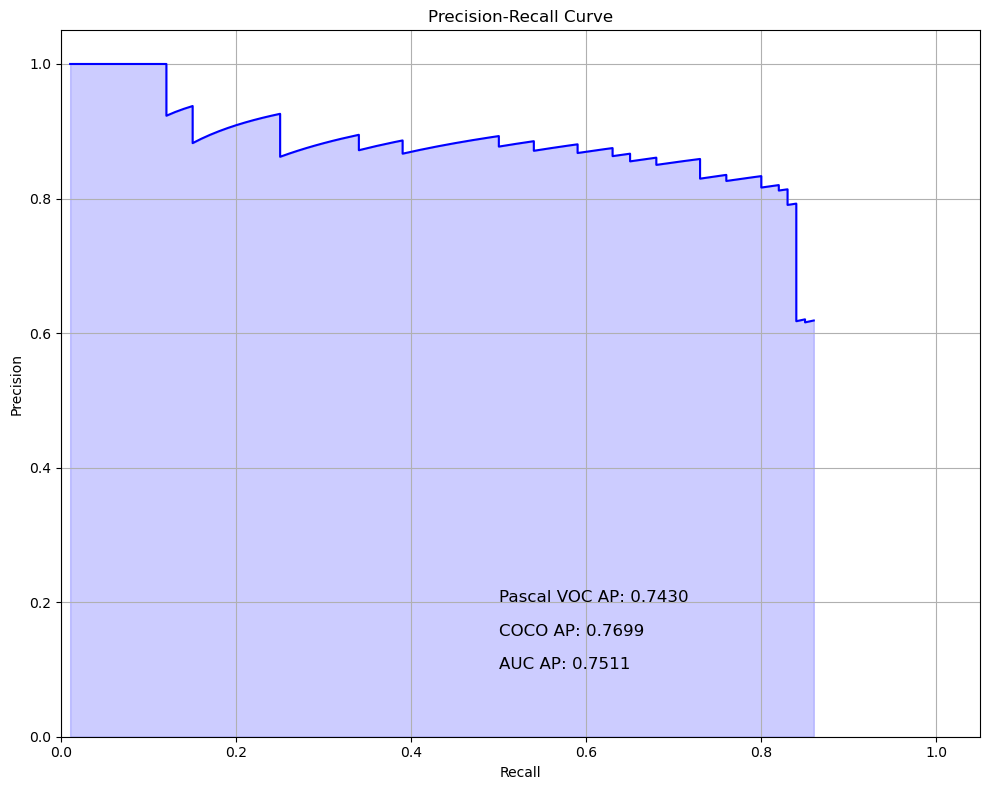

In [14]:
# Visualize the precision-recall curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, 'b-', label='Precision-Recall curve')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.grid(True)

# Add AP values to the plot
plt.text(0.5, 0.2, f"Pascal VOC AP: {ap_pascal_voc:.4f}", fontsize=12)
plt.text(0.5, 0.15, f"COCO AP: {ap_coco:.4f}", fontsize=12)
plt.text(0.5, 0.1, f"AUC AP: {ap_auc:.4f}", fontsize=12)

plt.tight_layout()
plt.show()

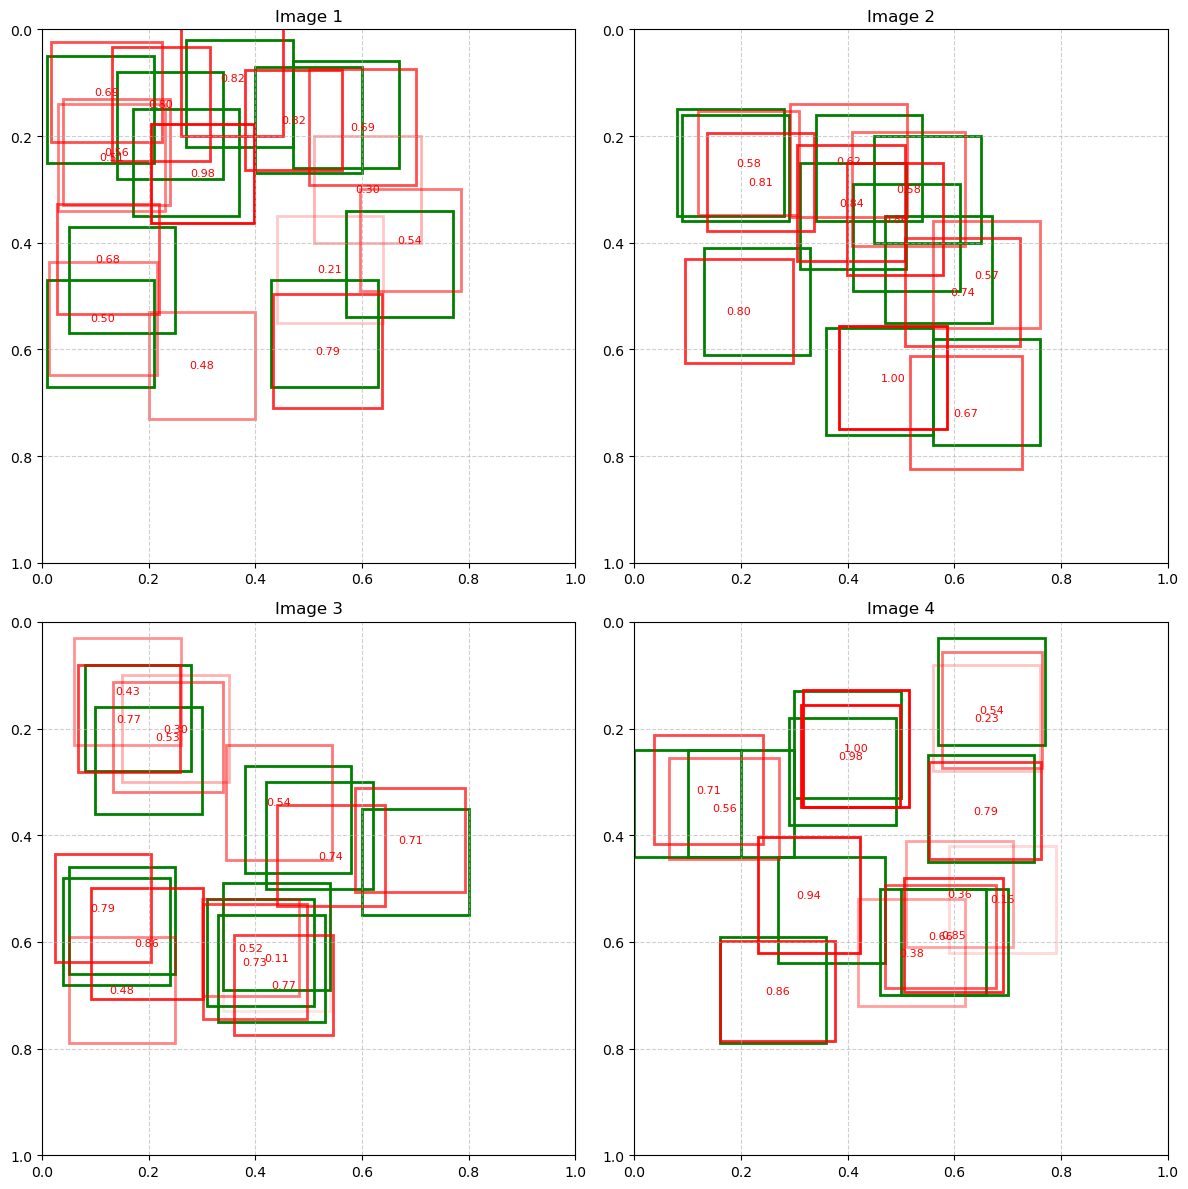

In [15]:
# Visualize some of the generated boxes for verification
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax_idx, img_idx in enumerate(range(4)):  # Show first 4 images
    ax = axes[ax_idx]
    
    # Create empty image
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()  # To match image coordinates (origin at top-left)
    
    # Plot ground truth boxes (in green)
    gt_patches = []
    for gt_box in gt_boxes[img_idx]:
        x, y, w, h = gt_box
        rect = patches.Rectangle(
            (x - w/2, y - h/2), w, h, 
            linewidth=2, edgecolor='g', facecolor='none'
        )
        gt_patches.append(rect)
    
    # Plot predicted boxes (in red)
    pred_patches = []
    for pred_box, score in zip(pred_boxes[img_idx], pred_scores[img_idx]):
        x, y, w, h = pred_box
        rect = patches.Rectangle(
            (x - w/2, y - h/2), w, h, 
            linewidth=2, edgecolor='r', facecolor='none', alpha=score
        )
        pred_patches.append(rect)
        
        # Add score text
        ax.text(x, y, f"{score:.2f}", color='red', fontsize=8,
                ha='center', va='center')
    
    # Add all patches to the plot
    for patch in gt_patches + pred_patches:
        ax.add_patch(patch)
    
    ax.set_title(f"Image {img_idx+1}")
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()